In [128]:
import itertools
import pandas as pd
import utils
from collections import defaultdict, OrderedDict
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
from scipy.sparse import hstack, vstack
import tensorflow as tf
from nn_models import TextCNN, TextCNN_field_aware, TextRNN, TextRNN_field_aware, TextRNN_attention
import data_helpers
import os
import time
import datetime
import pickle
import copy
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import precision_recall_curve, roc_curve, accuracy_score    

In [129]:
ORDERED_NAMES = [u'study',
                 u'history',
                 u'comparison',
                 u'technique',
                 u'findings',
                 u'impression', 
                 u'signed by',
                 ]

---
# Data Prep

In [136]:
# Load
df_processed = pickle.load(open('Data/DataFrame_processed.p', 'rb'))

TO_PREDICT = 'Past'
FIELDS = [
    'history',
    'findings',
    'comparison',
    'impression',
#     'Grade',
#     'Present',
#     'Past'
]

# df_filtered = df_processed[~df_processed[TO_PREDICT].isnull() & (df_processed[TO_PREDICT] != 0)].sample(frac=1, random_state=1)
df_filtered = df_processed[~df_processed[TO_PREDICT].isnull()].sample(frac=1, random_state=1)
df_filtered = df_filtered[[TO_PREDICT] + FIELDS]

df_train = df_filtered.iloc[:1220]
y_train = np.array(df_train[TO_PREDICT].astype(int))
enc = LabelEncoder()
enc.fit(y_train)
y_train = enc.transform(y_train)

df_test = df_filtered.iloc[1220:]
y_test = np.array(df_test[TO_PREDICT].astype(int))
y_test = enc.transform(y_test)

print(df_train.shape)
print(df_test.shape)
df_filtered[TO_PREDICT].value_counts()

(1220, 5)
(307, 5)


-1    1172
 1     355
Name: Past, dtype: int64

---
---
# Neural Nets

**Data Prep**

In [107]:
df_train.columns

Index(['Past', 'history', 'findings', 'comparison', 'impression'], dtype='object')

In [108]:
maxlen = [100,
          125,
          50,
          100]

In [109]:
x_train_text = utils.Dataframe_Proc.df2text(df_train, df_train.columns[1:])
word2idx, idx2word = utils.Text_Proc.ngram_vocab_processor(x_train_text, ngram=1, min_count=2)
x_train = np.array(utils.Text_Proc.encode_texts(x_train_text, word2idx, maxlen=sum(maxlen)))

enc = OneHotEncoder(sparse=False)
y_train = enc.fit_transform(y_train[:, None])

x_dev_text = utils.Dataframe_Proc.df2text(df_test, df_test.columns[1:])
x_dev = np.array(utils.Text_Proc.encode_texts(x_dev_text, word2idx, maxlen=x_train.shape[1]))

y_dev = enc.transform(y_test[:, None])

/Users/zyzzhaoyuzhe/virtualenvs/nlp3/lib/python3.7/site-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


In [110]:
x_train.shape

(1220, 375)

In [111]:
foo = pickle.load(open("Data/DataFrame_nns.p", "rb"))
x_train = foo['x_train']
x_dev = foo['x_dev']
word2idx = foo['word2idx']
idx2word = foo['idx2word']

In [112]:
len(word2idx)

1386

### NN Models

In [113]:
# Clear flags
if "FLAGS" in locals():
    for key in [key for key in FLAGS._flags().keys()]:
        FLAGS.__delattr__(key)

# Both CNN and RNN
tf.flags.DEFINE_integer("embedding_dim", 64, "Dimensionality of character embedding (default: 128)")
tf.flags.DEFINE_float("dropout_keep_prob", 0.5, "Dropout keep probability (default: 0.5)")
tf.flags.DEFINE_float("l2_reg_lambda", 0.1, "L2 regularization lambda (default: 0.0)")

# CNN parameter
tf.flags.DEFINE_string("filter_sizes", "3,4", "Comma-separated filter sizes (default: '3,4,5')")
tf.flags.DEFINE_integer("num_filters", 128, "Number of filters per filter size (default: 128)")

# RNN parameter
tf.flags.DEFINE_integer('hidden_size', 128, 'Hidden size of LSTM')
tf.flags.DEFINE_integer('num_layers', 1, 'Number of LSTM layers')

# Training parameters
tf.flags.DEFINE_integer("batch_size", 64, "Batch Size (default: 64)")
tf.flags.DEFINE_float("learning_rate", 1e-3, "learning rate")
tf.flags.DEFINE_integer("num_epochs", 100, "Number of training epochs (default: 200)")
tf.flags.DEFINE_integer("evaluate_every", 100, "Evaluate model on dev set after this many steps (default: 100)")
tf.flags.DEFINE_integer("checkpoint_every", 100, "Save model after this many steps (default: 100)")
tf.flags.DEFINE_integer("num_checkpoints", 0, "Number of checkpoints to store (default: 5)")
tf.flags.DEFINE_integer("log_every", 10, "Logs model on dev set after this many steps (default: 100)")

# Control
tf.flags.DEFINE_string("init_checkpoint", 
                       "runs/CNN-Field-Aware-Past-1700/checkpoints/model-1700",
                       "Checkpoint.")
tf.flags.DEFINE_boolean("do_train", False, "Do training")
tf.flags.DEFINE_boolean("do_eval", True, "Do evaluation")


# Misc Parameters
tf.flags.DEFINE_boolean("allow_soft_placement", True, "Allow device soft device placement")
tf.flags.DEFINE_boolean("log_device_placement", False, "Log placement of ops on devices")

# Fix Bugs 
tf.app.flags.DEFINE_string('f', '', 'kernel')

FLAGS = tf.flags.FLAGS
# FLAGS._parse_flags()
print("\nParameters:")
for attr, value in sorted(FLAGS.__flags.items()):
    print("{}={}".format(attr.upper(), value))
print("")


Parameters:
ALLOW_SOFT_PLACEMENT=<absl.flags._flag.BooleanFlag object at 0x13c161710>
BATCH_SIZE=<absl.flags._flag.Flag object at 0x133586ac8>
CHECKPOINT_EVERY=<absl.flags._flag.Flag object at 0x133586eb8>
DO_EVAL=<absl.flags._flag.BooleanFlag object at 0x13c161ba8>
DO_TRAIN=<absl.flags._flag.BooleanFlag object at 0x13c161be0>
DROPOUT_KEEP_PROB=<absl.flags._flag.Flag object at 0x133586860>
EMBEDDING_DIM=<absl.flags._flag.Flag object at 0x1335866d8>
EVALUATE_EVERY=<absl.flags._flag.Flag object at 0x133586dd8>
F=<absl.flags._flag.Flag object at 0x13c161208>
FILTER_SIZES=<absl.flags._flag.Flag object at 0x1335867f0>
HIDDEN_SIZE=<absl.flags._flag.Flag object at 0x133586be0>
INIT_CHECKPOINT=<absl.flags._flag.Flag object at 0x13c161e10>
L2_REG_LAMBDA=<absl.flags._flag.Flag object at 0x133586710>
LEARNING_RATE=<absl.flags._flag.Flag object at 0x133586cc0>
LOG_DEVICE_PLACEMENT=<absl.flags._flag.BooleanFlag object at 0x13c161f60>
LOG_EVERY=<absl.flags._flag.Flag object at 0x13c161a20>
NUM_CHEC

In [114]:
with tf.Graph().as_default():
    session_conf = tf.ConfigProto(
      allow_soft_placement=FLAGS.allow_soft_placement,
      log_device_placement=FLAGS.log_device_placement)
    sess = tf.Session(config=session_conf)
    with sess.as_default():
        
#         model = TextCNN(
#             sequence_length=x_train.shape[1],
#             num_classes=y_train.shape[1],
#             vocab_size=len(word2idx),
#             embedding_size=FLAGS.embedding_dim,
#             filter_sizes=list(map(int, FLAGS.filter_sizes.split(","))),
#             num_filters=FLAGS.num_filters,
#             l2_reg_lambda=FLAGS.l2_reg_lambda)

        model = TextCNN_field_aware(sequence_lengths=maxlen,
                                    num_classes=y_train.shape[1],
                                    vocab_size=len(word2idx),
                                    embedding_size=FLAGS.embedding_dim,
                                    filter_sizes=list(map(int, FLAGS.filter_sizes.split(","))),
                                    num_filters=FLAGS.num_filters,
                                    l2_reg_lambda=FLAGS.l2_reg_lambda)

#         model = TextRNN(sequence_length=sum(maxlen),
#                         num_classes=y_train.shape[1],
#                         vocab_size=len(word2idx),
#                         embedding_size=FLAGS.embedding_dim,
#                         hidden_size=FLAGS.hidden_size,
#                         num_layers=FLAGS.num_layers,
#                         l2_reg_lambda=FLAGS.l2_reg_lambda)

#         model = TextRNN_field_aware(sequence_lengths=maxlen,
#                                     num_classes=y_train.shape[1],
#                                     vocab_size=len(word2idx),
#                                     embedding_size=FLAGS.embedding_dim,
#                                     hidden_size=FLAGS.hidden_size,
#                                     num_layers=FLAGS.num_layers,
#                                     l2_reg_lambda=FLAGS.l2_reg_lambda)

#         model = TextRNN_attention(sequence_length=sum(maxlen),
#                         num_classes=y_train.shape[1],
#                         vocab_size=len(word2idx),
#                         embedding_size=FLAGS.embedding_dim,
#                         hidden_size=FLAGS.hidden_size,
#                         num_layers=FLAGS.num_layers,
#                         l2_reg_lambda=FLAGS.l2_reg_lambda)


        # Define Training procedure
        global_step = tf.Variable(0, name="global_step", trainable=False)
        # optimizer = tf.train.GradientDescentOptimizer(1e-3)
        optimizer = tf.train.AdamOptimizer(FLAGS.learning_rate)
        grads_and_vars = optimizer.compute_gradients(model.loss)
        train_op = optimizer.apply_gradients(grads_and_vars, global_step=global_step)

        # Keep track of gradient values and sparsity (optional)
        grad_summaries = []
        for g, v in grads_and_vars:
            if g is not None:
                grad_hist_summary = tf.summary.histogram("{}/grad/hist".format(v.name), g)
                sparsity_summary = tf.summary.scalar("{}/grad/sparsity".format(v.name), tf.nn.zero_fraction(g))
                grad_summaries.append(grad_hist_summary)
                grad_summaries.append(sparsity_summary)
        grad_summaries_merged = tf.summary.merge(grad_summaries)

        # Output directory for models and summaries
        timestamp = str(int(time.time()))

        if 'CNN' in model.__class__.__name__:
            name = "CNN_{}_{}_".format(FLAGS.embedding_dim, FLAGS.num_filters)
        elif 'RNN' in model.__class__.__name__:
            name = "RNN_{}_{}_{}_".format(FLAGS.embedding_dim, FLAGS.hidden_size, FLAGS.num_layers)


        out_dir = os.path.abspath(os.path.join(os.path.curdir, "runs", name + timestamp))
        print("Writing to {}\n".format(out_dir))

        # Summaries for loss and accuracy
        loss_summary = tf.summary.scalar("loss", model.loss)
        acc_summary = tf.summary.scalar("accuracy", model.accuracy)

        # Train Summaries
        train_summary_op = tf.summary.merge([loss_summary, acc_summary, grad_summaries_merged])
        train_summary_dir = os.path.join(out_dir, "summaries", "train")
        train_summary_writer = tf.summary.FileWriter(train_summary_dir, sess.graph)

        # Dev summaries
        dev_summary_op = tf.summary.merge([loss_summary, acc_summary])
        dev_summary_dir = os.path.join(out_dir, "summaries", "dev")
        dev_summary_writer = tf.summary.FileWriter(dev_summary_dir, sess.graph)

        # Checkpoint directory. Tensorflow assumes this directory already exists so we need to create it
        checkpoint_dir = os.path.abspath(os.path.join(out_dir, "checkpoints"))
        checkpoint_prefix = os.path.join(checkpoint_dir, "model")
        if not os.path.exists(checkpoint_dir):
            os.makedirs(checkpoint_dir)
        print(tf.global_variables())
        saver = tf.train.Saver(tf.global_variables(), max_to_keep=FLAGS.num_checkpoints)
        
        # Initialize from checkpoint
        if FLAGS.init_checkpoint:
            restorer = tf.train.Saver(tf.global_variables())
            restorer.restore(sess, FLAGS.init_checkpoint)
        else:
            # Initialize all variables
            sess.run(tf.global_variables_initializer())
            

        # Write vocabulary
        # vocab_processor.save(os.path.join(out_dir, "vocab"))
        
        def train_step(x_batch, y_batch):
            """
            A single training step
            """
            feed_dict = {
                model.input_x: x_batch,
                model.input_y: y_batch,
                model.dropout_keep_prob: FLAGS.dropout_keep_prob,
                model.batch_size: len(x_batch)
            }

            _, step, summaries, loss, accuracy = sess.run(
                [train_op, global_step, train_summary_op, model.loss, model.accuracy],
                feed_dict)
            time_str = datetime.datetime.now().isoformat()
            if step % FLAGS.log_every == 0:
                print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
            train_summary_writer.add_summary(summaries, step)

        def dev_step(x_batch, y_batch, writer=None):
            """
            Evaluates model on a dev set
            """
            feed_dict = {
                model.input_x: x_batch,
                model.input_y: y_batch,
                model.dropout_keep_prob: 1.0,
                model.batch_size: len(x_batch)
            }

            step, summaries, loss, accuracy = sess.run(
                [global_step, dev_summary_op, model.loss, model.accuracy],
                feed_dict)
            time_str = datetime.datetime.now().isoformat()
            print("{}: step {}, loss {:g}, acc {:g}".format(time_str, step, loss, accuracy))
            if writer:
                writer.add_summary(summaries, step)

        
        if FLAGS.do_train:
            # Generate batches
            batches = data_helpers.batch_iter(
                list(zip(x_train, y_train)), FLAGS.batch_size, FLAGS.num_epochs)
            # Training loop. For each batch...
            for batch in batches:
                x_batch, y_batch = zip(*batch)

                train_step(x_batch, y_batch)
                current_step = tf.train.global_step(sess, global_step)
                if current_step % FLAGS.evaluate_every == 0:
                    print("\nEvaluation:")
                    dev_step(x_dev, y_dev, writer=dev_summary_writer)
                    print("")
                if current_step % FLAGS.checkpoint_every == 0:
                    path = saver.save(sess, checkpoint_prefix, global_step=current_step)
                    print("Saved model checkpoint to {}\n".format(path))

        if FLAGS.do_eval:
            feed_dict = {
                model.input_x: x_dev,
                model.input_y: y_dev,
                model.dropout_keep_prob: 1.0,
                model.batch_size: len(x_dev)
            }
            y_dev_pred = sess.run([model.predictions], feed_dict=feed_dict)
            y_dev_prob = sess.run([tf.nn.softmax(model.logits, axis=1)], feed_dict=feed_dict)
    #         y_dev_pred, alpha = sess.run([model.predictions, model.alpha], feed_dict=feed_dict)

INFO:tensorflow:Summary name embedding/Variable:0/grad/hist is illegal; using embedding/Variable_0/grad/hist instead.
INFO:tensorflow:Summary name embedding/Variable:0/grad/sparsity is illegal; using embedding/Variable_0/grad/sparsity instead.
INFO:tensorflow:Summary name CNN_0/conv-maxpool-3/W:0/grad/hist is illegal; using CNN_0/conv-maxpool-3/W_0/grad/hist instead.
INFO:tensorflow:Summary name CNN_0/conv-maxpool-3/W:0/grad/sparsity is illegal; using CNN_0/conv-maxpool-3/W_0/grad/sparsity instead.
INFO:tensorflow:Summary name CNN_0/conv-maxpool-3/b:0/grad/hist is illegal; using CNN_0/conv-maxpool-3/b_0/grad/hist instead.
INFO:tensorflow:Summary name CNN_0/conv-maxpool-3/b:0/grad/sparsity is illegal; using CNN_0/conv-maxpool-3/b_0/grad/sparsity instead.
INFO:tensorflow:Summary name CNN_0/conv-maxpool-4/W:0/grad/hist is illegal; using CNN_0/conv-maxpool-4/W_0/grad/hist instead.
INFO:tensorflow:Summary name CNN_0/conv-maxpool-4/W:0/grad/sparsity is illegal; using CNN_0/conv-maxpool-4/W_0

INFO:tensorflow:Restoring parameters from runs/CNN-Field-Aware-Past-1700/checkpoints/model-1700


In [115]:
# PR Curve
pr_curves = []  # reset 

In [116]:
_y_true = y_test
_y_pred = y_dev_prob[0][:, -1]

In [117]:
pr_curves.append(precision_recall_curve(_y_true, _y_pred, pos_label=2))

/Users/zyzzhaoyuzhe/virtualenvs/nlp3/lib/python3.7/site-packages/sklearn/metrics/ranking.py:526: RuntimeWarning: invalid value encountered in true_divide
  recall = tps / tps[-1]


In [ ]:
for pr_curve in pr_curves[-3:]:
    plt.plot(pr_curve[1], pr_curve[0])
plt.legend(["RNN-Attention", "CNN", "Logistic Regression"],fontsize=14)
plt.xlabel('Recall', fontsize=16)
plt.ylabel('Precision', fontsize=16)
plt.savefig('images/predict_past_pr_curve.pdf', dpi=600)

In [118]:
from sklearn.metrics import accuracy_score, f1_score

In [123]:
precision, recall, thres = pr_curves[0]
target_thres = 0.3
print(np.min(np.abs(thres - target_thres)))
print(precision[np.argmin(np.abs(thres - target_thres))], recall[np.argmin(np.abs(thres - target_thres))])
print(f1_score(y_test==1, _y_pred > target_thres))

0.6989311
0.0 nan
0.7899159663865546


In [ ]:
# ROC curve
rocs = []  # reset 

In [ ]:
_y_true = y_test
_y_pred = y_dev_prob[0][:, -1]

In [ ]:
rocs.append(roc_curve(_y_true, _y_pred, pos_label=2))

In [ ]:
for roc in rocs[-3:]:
    plt.plot(roc[0], roc[1])
plt.legend(["RNN-Attention", "CNN", "Logistic Regression"], fontsize=14)
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.savefig('images/predict_present_roc_curve.pdf', dpi=600)

In [101]:
utils.my_classification_report(y_test==2, y_dev_prob[0][:, -1]>0.5)

sensitivity    0.898551
specificity    0.949580
precision      0.837838
accuracy       0.938111
f1             0.867133
dtype: float64

In [124]:
model = "TextRNN_field_aware"
output = utils.output_report(y_test==1, y_dev_prob[0][:, -1]>0.3)
print(output)
# output.to_csv("CI/" + model +'.csv', header=False)

sensitivity               0.746032
specificity               0.963115
precision                 0.839286
accuracy                  0.918567
f1                        0.789916
sensitivity CI    [0.6471, 0.8308]
specificity CI    [0.9435, 0.9802]
precision CI      [0.7586, 0.9138]
accuracy CI       [0.8925, 0.9446]
f1 CI             [0.7107, 0.8546]
dtype: object


In [145]:
output = utils.output_report_diff(y1==1, y1_prob > 0.4, y_test==1, y_dev_prob[0][:, -1]>0.3)
print(output)

sensitivity              -0.0793651
specificity               0.0532787
precision                  0.136583
accuracy                  0.0260586
f1                        0.0307919
sensitivity CI    [-0.1965, 0.0402]
specificity CI     [0.0163, 0.0887]
precision CI       [0.0106, 0.2556]
accuracy CI       [-0.0098, 0.0619]
f1 CI             [-0.0649, 0.1226]
dtype: object


## ML

### TFIDF features

In [137]:
ngram, min_count = 2, 10

obj = utils.Df2TFIDF()
obj.fit(df_train, ngram=ngram, min_count=min_count)
output_train = obj.transform(df_train)
output_test = obj.transform(df_test)
# concatenate sparse matrices of all fields
x_train = hstack([foo['bow_tfidf'] for foo in output_train.values()])
x_test = hstack([foo['bow_tfidf'] for foo in output_test.values()])

print(x_train.shape)
print(x_test.shape)

(1220, 2346)
(307, 2346)


### Run classifier

In [138]:
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import LogisticRegression
# svm
# clf = LinearSVC(C=1, loss='squared_hinge')
# clf = SVC()
clf = LogisticRegression(C=5)

clf.fit(x_train, y_train)
coef = clf.coef_.squeeze()

/Users/zyzzhaoyuzhe/virtualenvs/nlp3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [144]:
y_train_pred = clf.predict(x_train)
y_test_pred = clf.predict(x_test)
y_test_prob = clf.predict_proba(x_test)
results = pd.concat([utils.my_classification_report(y_train==1, y_train_pred==1),
                     utils.my_classification_report(y_test==1, y_test_prob[:,-1]>0.4),
                     ], axis=1).transpose()
results.index = ['training', 'testing']
display(results)

,sensitivity,specificity,precision,accuracy,f1
training,0.952055,1.000000,1.000000,0.988525,0.975439
testing,0.825397,0.909836,0.702703,0.892508,0.759124


In [140]:
# Rename for Plottling PR/ROC Curve.
_y_true = y_test==1
_y_pred = y_test_prob[:, -1]

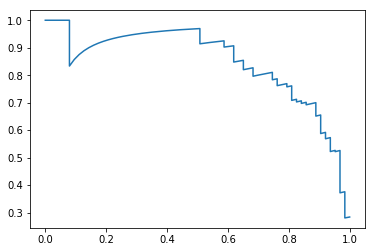

In [141]:
pr_curve = precision_recall_curve(_y_true, _y_pred, pos_label=1)
plt.plot(pr_curve[1], pr_curve[0])

In [142]:
# For Diff CI
y1 = y_test
y1_prob = y_test_prob[:, -1]